### **Problem Statement:** Predict sales from items sold at Corporación Favorita, a large Ecuadorian-based grocery retailer using Time Series Analysis

##### - **Method:** Utilized various time series models to predict over the next 15 days and evaluated performance of the models
##### - **Approach:** Using data from Kaggle
##### - **Metric:** Measure the accuracy of forecasted figures

### 1) Import libraries and load data

In [1]:
import pandas as pd
import numpy as np
import datetime
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore") 

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.api import VAR
from prophet import Prophet
from statsmodels.tsa.vector_ar.vecm import VECM

Importing plotly failed. Interactive plots will not work.


In [2]:
df_stores = pd.read_csv('./stores.csv')
df_holidays = pd.read_csv('./holidays_events.csv')
df_oil = pd.read_csv('./oil.csv')
df_transactions = pd.read_csv('./transactions.csv')
df = pd.read_csv('./train.csv')

### 2) EDA

In [3]:
df_stores.dtypes

store_nbr     int64
city         object
state        object
type         object
cluster       int64
dtype: object

In [4]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [5]:
# Change city datatype to category for ease of handling
df_stores['city'] = df_stores['city'].astype('category')
df_stores[['store_nbr', 'city']].dtypes

store_nbr       int64
city         category
dtype: object

In [6]:
df_store_city = df_stores[['store_nbr', 'city']].copy()

In [7]:
print(df_store_city.shape, 'null:', df_store_city.isnull().sum().sum())
df_store_city.select_dtypes(include='category').describe()

(54, 2) null: 0


,city
count,54
unique,22
top,Quito
freq,18


#### Holiday data

In [8]:
print(df_holidays.shape)
df_holidays.head()

(350, 6)


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [9]:
df_holidays['date'].dtypes

dtype('O')

In [10]:
df_holidays['date'] = pd.to_datetime(df_holidays['date'])
df_holidays_deduped = df_holidays.drop_duplicates(subset=['date'])
df_holidays_deduped = df_holidays_deduped[['date']]
df_holidays_deduped['is_holiday'] = 1
print(df_holidays_deduped.shape)
df_holidays_deduped.head()

(312, 2)


,date,is_holiday
0,2012-03-02,1
1,2012-04-01,1
2,2012-04-12,1
3,2012-04-14,1
4,2012-04-21,1


In [11]:
df_holidays_deduped.select_dtypes(include='datetime').describe()

,date
count,312
mean,2015-04-24 00:55:23.076923136
min,2012-03-02 00:00:00
25%,2013-12-24 18:00:00
50%,2015-05-11 00:00:00
75%,2016-07-08 00:00:00
max,2017-12-26 00:00:00


In [12]:
df_holidays_deduped.dtypes

date          datetime64[ns]
is_holiday             int64
dtype: object

#### Oil Price data

In [13]:
df_oil.dtypes

date           object
dcoilwtico    float64
dtype: object

In [14]:
df_oil['date'] = pd.to_datetime(df_oil['date'], format='%Y-%m-%d')

In [15]:
df_oil.dtypes

date          datetime64[ns]
dcoilwtico           float64
dtype: object

In [16]:
print(df_oil.shape, 'null:', df_oil.isnull().sum().sum())
df_oil.describe()

(1218, 2) null: 43


,date,dcoilwtico
count,1218,1175.000000
mean,2015-05-02 12:00:00,67.714366
min,2013-01-01 00:00:00,26.190000
25%,2014-03-03 06:00:00,46.405000
50%,2015-05-02 12:00:00,53.190000
75%,2016-06-30 18:00:00,95.660000
max,2017-08-31 00:00:00,110.620000
std,NaN,25.630476


In [17]:
full_date_range = pd.date_range(start=df_oil['date'].min(), end=df_oil['date'].max(), freq='D')
missing_dates = set(full_date_range) - set(df_oil['date'].unique())
missing_dates = list(missing_dates)
len(missing_dates)

486

In [18]:
missing_rows = pd.DataFrame({'date': missing_dates,
                             'dcoilwtico': np.nan})
missing_rows['date'] = missing_rows['date'].dt.date
df_oil['date'] = df_oil['date'].dt.date
df_oil_new = pd.concat([missing_rows, df_oil], ignore_index=True)
df_oil_new.sort_values(by='date', ascending=True, inplace=True)
print(df_oil_new.shape)

(1704, 2)


In [19]:
df_oil_new['dcoilwtico'].interpolate()
df_oil_int = df_oil_new.bfill()

In [20]:
df_oil_int.isnull().sum()

date          0
dcoilwtico    0
dtype: int64

#### Transactions data

In [21]:
df_transactions.dtypes

date            object
store_nbr        int64
transactions     int64
dtype: object

In [22]:
df_transactions['date'] = pd.to_datetime(df_transactions['date'], format='%Y-%m-%d')

In [23]:
df_transactions.dtypes

date            datetime64[ns]
store_nbr                int64
transactions             int64
dtype: object

In [24]:
print(df_transactions.shape, 'null:', df_transactions.isnull().sum().sum())
df_transactions.describe()

(83488, 3) null: 0


,date,store_nbr,transactions
count,83488,83488.000000,83488.000000
mean,2015-05-20 16:07:40.866232064,26.939237,1694.602158
min,2013-01-01 00:00:00,1.000000,5.000000
25%,2014-03-27 00:00:00,13.000000,1046.000000
50%,2015-06-08 00:00:00,27.000000,1393.000000
75%,2016-07-14 06:00:00,40.000000,2079.000000
max,2017-08-15 00:00:00,54.000000,8359.000000
std,NaN,15.608204,963.286644


In [25]:
df_transactions_grp = df_transactions[['date', 'transactions']].groupby(by=['date']).mean()
df_transactions_grp.reset_index(inplace=True)
df_transactions_grp['date'] = pd.to_datetime(df_transactions_grp['date'], format='%Y-%m-%d')
print(df_transactions_grp.shape)
df_transactions_grp

(1682, 2)


,date,transactions
0,2013-01-01,770.000000
1,2013-01-02,2026.413043
2,2013-01-03,1706.608696
3,2013-01-04,1706.391304
4,2013-01-05,2034.195652
...,...,...
1677,2017-08-11,1658.351852
1678,2017-08-12,1665.314815
1679,2017-08-13,1592.462963
1680,2017-08-14,1582.370370


In [26]:
full_date_range = pd.date_range(start=df_transactions_grp['date'].min(), end=df_transactions_grp['date'].max(), freq='D')
missing_dates = set(full_date_range) - set(df_transactions_grp['date'].unique())
missing_dates = list(missing_dates)
len(missing_dates)

6

In [27]:
missing_rows = pd.DataFrame({'date': missing_dates,
                             'transactions': np.nan})
missing_rows['date'] = pd.to_datetime(missing_rows['date'], format='%Y-%m-%d')
missing_rows

,date,transactions
0,2016-01-01,NaN
1,2015-12-25,NaN
2,2016-01-03,NaN
3,2016-12-25,NaN
4,2013-12-25,NaN
5,2014-12-25,NaN


In [28]:
df_transactions_grp['date'] = pd.to_datetime(df_transactions_grp['date'], format='%Y-%m-%d')
df_transactions_grp_new = pd.concat([missing_rows, df_transactions_grp], ignore_index=True)
df_transactions_grp_new.sort_values(by='date', ascending=True, inplace=True)
print(df_transactions_grp_new.shape)

(1688, 2)


In [29]:
df_merge_grp = df_transactions_grp_new.merge(df_holidays_deduped, how='left', on='date')
print(df_merge_grp.shape)
df_merge_grp.head()

(1688, 3)


,date,transactions,is_holiday
0,2013-01-01,770.000000,1.0
1,2013-01-02,2026.413043,NaN
2,2013-01-03,1706.608696,NaN
3,2013-01-04,1706.391304,NaN
4,2013-01-05,2034.195652,1.0


In [30]:
df_merge_grp['transactions'].isnull().sum().sum()

np.int64(6)

In [31]:
df_merge_grp['is_holiday'] = df_merge_grp['is_holiday'].fillna(0)

In [32]:
df_merge_grp['transactions'].interpolate()
df_merge_grp_int = df_merge_grp.bfill()

In [33]:
df_merge_grp_int.isnull().sum()

date            0
transactions    0
is_holiday      0
dtype: int64

In [34]:
df_merge_grp_int.dtypes

date            datetime64[ns]
transactions           float64
is_holiday             float64
dtype: object

#### df data

In [35]:
df[['date', 'sales']].dtypes

date      object
sales    float64
dtype: object

In [36]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df_grp = df[['date', 'sales']].groupby(by='date').sum()
df_grp.reset_index(inplace=True)
print(df_grp.shape)

(1684, 2)


In [37]:
df_grp.dtypes

date     datetime64[ns]
sales           float64
dtype: object

In [38]:
df_grp.isnull().sum()

date     0
sales    0
dtype: int64

In [39]:
df_grp.describe()

,date,sales
count,1684,1.684000e+03
mean,2015-04-24 08:27:04.703088128,6.375564e+05
min,2013-01-01 00:00:00,2.511619e+03
25%,2014-02-26 18:00:00,4.427115e+05
50%,2015-04-24 12:00:00,6.321889e+05
75%,2016-06-19 06:00:00,7.859455e+05
max,2017-08-15 00:00:00,1.463084e+06
std,NaN,2.344102e+05


In [40]:
df_oil_int['date'].dtype

dtype('O')

In [41]:
df_oil_int['date'] = pd.to_datetime(df_oil_int['date'], format='%Y-%m-%d')
df_new = pd.merge(df_grp, df_oil_int, how='left', on=['date'])
print(df_new.shape)
df_new.head()

(1684, 3)


,date,sales,dcoilwtico
0,2013-01-01,2511.618999,93.14
1,2013-01-02,496092.417944,93.14
2,2013-01-03,361461.231124,92.97
3,2013-01-04,354459.677093,93.12
4,2013-01-05,477350.121229,93.20


In [42]:
df_merge_grp_int['date'] = pd.to_datetime(df_merge_grp_int['date'], format='%Y-%m-%d')
df_new = pd.merge(df_new, df_merge_grp_int, how='left', on=['date'])
df_new.set_index('date', inplace=True)
print(df_new.shape)
df_new.head()

(1684, 4)


,sales,dcoilwtico,transactions,is_holiday
date,,,,
2013-01-01,2511.618999,93.14,770.000000,1.0
2013-01-02,496092.417944,93.14,2026.413043,0.0
2013-01-03,361461.231124,92.97,1706.608696,0.0
2013-01-04,354459.677093,93.12,1706.391304,0.0
2013-01-05,477350.121229,93.20,2034.195652,1.0


In [43]:
df_new.isnull().sum()

sales           0
dcoilwtico      0
transactions    0
is_holiday      0
dtype: int64

In [44]:
df_new.describe()

,sales,dcoilwtico,transactions,is_holiday
count,1.684000e+03,1684.000000,1684.000000,1684.000000
mean,6.375564e+05,67.862162,1695.418862,0.149644
std,2.344102e+05,25.711860,226.933675,0.356828
min,2.511619e+03,26.190000,663.500000,0.000000
25%,4.427115e+05,46.320000,1546.431159,0.000000
50%,6.321889e+05,53.190000,1636.610397,0.000000
75%,7.859455e+05,95.802500,1816.159984,0.000000
max,1.463084e+06,110.620000,3315.872340,1.000000


In [45]:
df_new.shape[0]

1684

In [46]:
test_size = 15
og_training_set, og_test_set = df_new[:-test_size], df_new[-test_size:]

**Observation:**
- Train data: 2013 - Mid Aug 2017
- Oil data: 2013 - End Aug 2017
- Transaction data: 2013 - Mid Aug 2017

In [60]:
og_training_set['is_holiday'] = og_training_set['is_holiday'].astype('category')
og_training_set.dtypes

date            datetime64[ns]
sales                  float64
dcoilwtico             float64
transactions           float64
is_holiday            category
dtype: object

#### ADF test

In [48]:
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    
    if result[1] < 0.05:
        print("Reject the null hypothesis - The series is stationary")
    else:
        print("Fail to reject the null hypothesis - The series is non-stationary")

In [49]:
for variable in tqdm(og_training_set[['sales', 'dcoilwtico', 'transactions']].columns.tolist()):
    print(variable)
    adf_test(og_training_set[variable])

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 31.03it/s]

sales
ADF Statistic: -2.537990117612831
p-value: 0.10650235986862733
Critical Values: {'1%': np.float64(-3.4343290567280453), '5%': np.float64(-2.863297525562038), '10%': np.float64(-2.5677056661976674)}
Fail to reject the null hypothesis - The series is non-stationary
dcoilwtico
ADF Statistic: -0.9323176362084944
p-value: 0.7771435768007593
Critical Values: {'1%': np.float64(-3.43427885313169), '5%': np.float64(-2.863275365507293), '10%': np.float64(-2.5676938662645394)}
Fail to reject the null hypothesis - The series is non-stationary
transactions
ADF Statistic: -7.067466825273857
p-value: 5.037055942400552e-10
Critical Values: {'1%': np.float64(-3.4343290567280453), '5%': np.float64(-2.863297525562038), '10%': np.float64(-2.5677056661976674)}
Reject the null hypothesis - The series is stationary


In [50]:
training_set = og_training_set[['sales', 'dcoilwtico', 'transactions']].copy()
training_set['sales'] = training_set['sales'].diff()
training_set['sales'].replace([np.inf, -np.inf], np.nan, inplace=True)
training_set.dropna(subset=['sales'], inplace=True)

training_set['dcoilwtico'] = training_set['dcoilwtico'].diff()
training_set['dcoilwtico'].replace([np.inf, -np.inf], np.nan, inplace=True)
training_set.dropna(subset=['dcoilwtico'], inplace=True)

In [51]:
for variable in tqdm(training_set.columns.tolist()):
    print(variable)
    adf_test(training_set[variable])

  0%|                                                     | 0/3 [00:00<?, ?it/s]

sales


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 26.48it/s]

ADF Statistic: -11.420993005027945
p-value: 6.874454395211951e-21
Critical Values: {'1%': np.float64(-3.434341199650204), '5%': np.float64(-2.8633028854374762), '10%': np.float64(-2.5677085202688126)}
Reject the null hypothesis - The series is stationary
dcoilwtico
ADF Statistic: -42.35103248281877
p-value: 0.0
Critical Values: {'1%': np.float64(-3.4342812150354276), '5%': np.float64(-2.8632764080687307), '10%': np.float64(-2.5676944214132233)}
Reject the null hypothesis - The series is stationary
transactions
ADF Statistic: -7.088030221446249
p-value: 4.485231524559756e-10
Critical Values: {'1%': np.float64(-3.4343339050195465), '5%': np.float64(-2.8632996655963554), '10%': np.float64(-2.567706805740553)}
Reject the null hypothesis - The series is stationary


In [52]:
print(training_set.shape)
training_set.head()

(1667, 3)


,sales,dcoilwtico,transactions
date,,,
2013-01-03,-134631.186820,-0.17,1706.608696
2013-01-04,-7001.554031,0.15,1706.391304
2013-01-05,122890.444136,0.08,2034.195652
2013-01-06,42345.279859,0.00,1966.608696
2013-01-07,-183572.600022,0.00,1643.413043


In [54]:
training_set.reset_index(inplace=True)
og_training_set.reset_index(inplace=True)
df_training = training_set.merge(og_training_set[['date', 'is_holiday']], how='left', on='date')
df_training.set_index('date', inplace=True)
df_training

,sales,dcoilwtico,transactions,is_holiday
date,,,,
2013-01-03,-134631.186820,-0.17,1706.608696,0.0
2013-01-04,-7001.554031,0.15,1706.391304,0.0
2013-01-05,122890.444136,0.08,2034.195652,1.0
2013-01-06,42345.279859,0.00,1966.608696,0.0
2013-01-07,-183572.600022,0.00,1643.413043,0.0
...,...,...,...,...
2017-07-27,-80803.217108,0.47,1458.203704,0.0
2017-07-28,175249.855145,0.67,1651.796296,0.0
2017-07-29,197211.183534,0.49,1856.055556,0.0


In [66]:
df_training['is_holiday'] = df_training['is_holiday'].astype('category')
df_training.dtypes

sales            float64
dcoilwtico       float64
transactions     float64
is_holiday      category
dtype: object

#### Granger causality test

In [55]:
max_lag = 10
predictors = ['dcoilwtico', 'transactions']

for predictor in predictors:
    
    print(f'Granger Causality Test for {predictor} -> sales:')
    grangercausalitytests(training_set[['sales', predictor]], max_lag)
    print('\n')

Granger Causality Test for dcoilwtico -> sales:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5303  , p=0.4666  , df_denom=1663, df_num=1
ssr based chi2 test:   chi2=0.5313  , p=0.4661  , df=1
likelihood ratio test: chi2=0.5312  , p=0.4661  , df=1
parameter F test:         F=0.5303  , p=0.4666  , df_denom=1663, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2581  , p=0.2845  , df_denom=1660, df_num=2
ssr based chi2 test:   chi2=2.5238  , p=0.2831  , df=2
likelihood ratio test: chi2=2.5219  , p=0.2834  , df=2
parameter F test:         F=1.2581  , p=0.2845  , df_denom=1660, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7669  , p=0.5125  , df_denom=1657, df_num=3
ssr based chi2 test:   chi2=2.3105  , p=0.5105  , df=3
likelihood ratio test: chi2=2.3089  , p=0.5108  , df=3
parameter F test:         F=0.7669  , p=0.5125  , df_denom=1657, df_num=3

Granger Causality
number of lags (no ze

**Observation:**
- Significant Lags: Lags 2 and 5 showed significant Granger causality, indicating that past oil prices could help predict future sales for these specific lags.
- Overall Relationship: While some lags indicated a predictive relationship, the lack of significance in other lags suggests that the effect of oil prices on sales may not be consistent over time or may be affected by other variables.
- Significant Lags: All tested lags (1 through 10) show significant Granger causality, suggesting a consistent predictive relationship between transactions and sales. This means that past transaction data can reliably help forecast future sales across all lags tested.
- Implication: The strong relationship indicates that changes in transaction volumes are closely associated with changes in sales, making transaction data a useful predictor for sales forecasting.

#### Engle-Granger Cointegration Test (ADF test on residuals)

In [57]:
score, p_value, _ = coint(training_set['sales'], training_set['dcoilwtico'])
print(f'Cointegration test statistic dcoilwtico: {score}')
print(f'p-value dcoilwtico: {p_value}')

score, p_value, _ = coint(training_set['sales'], training_set['transactions'])
print(f'Cointegration test statistic transaction: {score}')
print(f'p-value transaction: {p_value}')

Cointegration test statistic dcoilwtico: -11.416525352663028
p-value dcoilwtico: 8.45941038668635e-20
Cointegration test statistic transaction: -7.559559804803959
p-value transaction: 3.7730758423404493e-10


**Observation:**
- Both dcoilwtico and transactions are cointegrated with sales, as indicated by the significantly negative test statistics and extremely low p-values.
- This means that there is a long-run equilibrium relationship between sales, dcoilwtico, and transactions, even if these series may individually exhibit non-stationary behavior. Despite short-term fluctuations, they move together over time, maintaining a stable long-term relationship.
- The presence of cointegration means that Vector Error Correction Model (VECM) can be used, which accounts for both short-term dynamics and the long-term equilibrium relationship between the variables.

### 3) Time Series Modelling

#### VAR

In [67]:
training_var = df_training.copy()

In [68]:
var_model = VAR(training_var)
var_model_fitted = var_model.fit(maxlags=5, ic='aic')
print(var_model_fitted.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 24, Oct, 2024
Time:                     15:00:50
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    30.8397
Nobs:                     1662.00    HQIC:                   30.6674
Log likelihood:          -34749.4    FPE:                1.88203e+13
AIC:                      30.5660    Det(Omega_mle):     1.78984e+13
--------------------------------------------------------------------
Results for equation sales
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const              215666.653409     33701.654959            6.399           0.000
L1.sales               -0.510649         0.030689          -16.639           0.000
L1.dcoilwtico       -4313.017718      2773.362029   

/Users/wanderlustzenn/Desktop/projects/base_py/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [73]:
lag_order = var_model_fitted.k_ar
var_forecast_input = training_var.values[-lag_order:]  # Use last observations as input
var_forecast = var_model_fitted.forecast(y=var_forecast_input, steps=15)

df_var_forecast = pd.DataFrame(var_forecast, columns=['sales', 'dcoilwtico', 'transactions', 'is_holiday'])
df_var_forecast['is_holiday'] = np.where(df_var_forecast['is_holiday'] >= 0.5, 1, 0)
df_var_forecast

,sales,dcoilwtico,transactions,is_holiday
0,-54910.667975,0.049953,1588.018666,0
1,-35057.507899,-0.033239,1527.881389,0
2,-5611.312397,0.016052,1524.160652,0
3,99239.374089,-0.015592,1655.046144,0
4,128660.964431,-0.091493,1823.869617,0
5,-32839.802642,-0.036983,1770.076911,0
6,-77257.655629,0.008696,1669.264126,0
7,-35014.834281,-0.003296,1621.514156,0
8,-20220.012224,0.010659,1586.803604,0
9,-2848.274244,-0.007865,1602.841191,0


In [74]:
sales_original = df_new[-16:-1]['sales'].values
dcoilwtico_original = df_new[-16:-1]['dcoilwtico'].values

sales_new = []
for original, change in zip(sales_original, df_var_forecast['sales'].values):
    new_value = original + change
    sales_new.append(new_value)

dcoilwtico_new = []
for original, change in zip(dcoilwtico_original, df_var_forecast['dcoilwtico'].values):
    new_value = original + change
    dcoilwtico_new.append(new_value)

df_sales_new = pd.DataFrame(sales_new, columns=['Predicted Sales'])
df_dcoilwtico_new = pd.DataFrame(dcoilwtico_new, columns=['Predicted dcoilwtico'])

In [77]:
df_test_dates = pd.DataFrame(og_test_set.index)
df_var_forecast['Predicted Transactions'] = df_var_forecast['transactions']
df_var_forecast_new = pd.concat([df_test_dates, df_sales_new, df_dcoilwtico_new, df_var_forecast[['Predicted Transactions', 'is_holiday']]], axis=1)
df_var_forecast_new.set_index('date', inplace=True)
df_var_forecast_new

,Predicted Sales,Predicted dcoilwtico,Predicted Transactions,is_holiday
date,,,,
2017-08-01,830946.172896,50.259953,1588.018666,0
2017-08-02,953470.255305,49.156761,1527.881389,0
2017-08-03,959100.703654,49.616052,1524.160652,0
2017-08-04,827307.859221,49.014408,1655.046144,0
2017-08-05,956436.650559,49.478507,1823.869617,0
2017-08-06,932853.847850,49.333017,1770.076911,0
2017-08-07,972301.508648,49.378696,1669.264126,0
2017-08-08,762450.129536,49.366704,1621.514156,0
2017-08-09,697546.336881,49.080659,1586.803604,0


In [78]:
test_var = og_test_set.copy()
df_var_forecast_final = pd.concat([test_var, df_var_forecast_new], axis=1)
df_var_forecast_final

,sales,dcoilwtico,transactions,is_holiday,Predicted Sales,Predicted dcoilwtico,Predicted Transactions,is_holiday
date,,,,,,,,
2017-08-01,9.885278e+05,49.19,1705.240741,0.0,830946.172896,50.259953,1588.018666,0
2017-08-02,9.647120e+05,49.60,1722.648148,0.0,953470.255305,49.156761,1527.881389,0
2017-08-03,7.280685e+05,49.03,1583.722222,0.0,959100.703654,49.616052,1524.160652,0
2017-08-04,8.277757e+05,49.57,1690.833333,0.0,827307.859221,49.014408,1655.046144,0
2017-08-05,9.656937e+05,49.37,1872.370370,1.0,956436.650559,49.478507,1823.869617,0
2017-08-06,1.049559e+06,49.37,1780.777778,0.0,932853.847850,49.333017,1770.076911,0
2017-08-07,7.974650e+05,49.37,1612.444444,0.0,972301.508648,49.378696,1669.264126,0
2017-08-08,7.177663e+05,49.07,1544.851852,0.0,762450.129536,49.366704,1621.514156,0
2017-08-09,7.341397e+05,49.59,1582.444444,0.0,697546.336881,49.080659,1586.803604,0


In [79]:
rmse_VAR = np.sqrt(mean_squared_error(df_var_forecast_final['sales'], df_var_forecast_final['Predicted Sales']))
print(f'RMSE: {rmse_VAR}')

RMSE: 104799.50135682609


In [80]:
# Function for calculating MAPE
def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    non_zero_mask = y_true != 0
    
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

In [81]:
MAPE(df_var_forecast_final['sales'], df_var_forecast_final['Predicted Sales'])

np.float64(10.15898146363742)

<Axes: xlabel='date'>

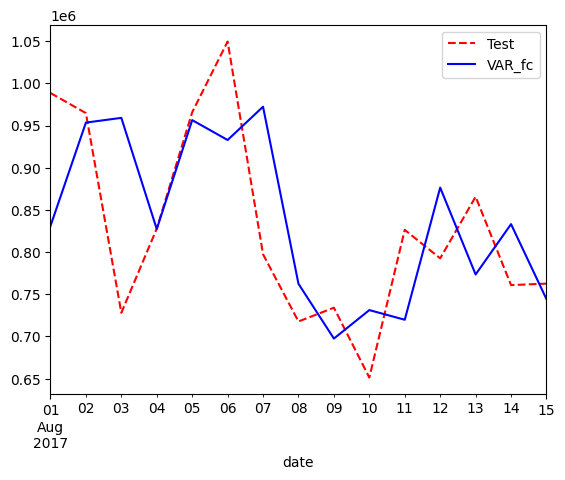

In [82]:
df_var_forecast_final['sales'].plot(style = '--', color = 'r', legend = True, label = 'Test')
df_var_forecast_final['Predicted Sales'].plot(color = 'b', legend = True, label = 'VAR_fc')

#### VECM

In [86]:
training_vecm = df_training.copy()

In [88]:
training_vecm.dtypes

sales            float64
dcoilwtico       float64
transactions     float64
is_holiday      category
dtype: object

In [89]:
k_ar_diff = 5 - 1 # optimal lag length from VAR model - 1
vecm_model = VECM(training_vecm, k_ar_diff=k_ar_diff)
vecm_model_fitted = vecm_model.fit()
print(vecm_model_fitted.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation sales
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
L1.sales            1.9995      0.079     25.299      0.000       1.845       2.154
L1.dcoilwtico   -8093.7770   2481.041     -3.262      0.001    -1.3e+04   -3231.025
L1.transactions   240.2554     24.201      9.928      0.000     192.823     287.688
L1.is_holiday   -1.341e+04   8237.019     -1.628      0.104   -2.96e+04    2733.781
L2.sales            1.3886      0.060     23.058      0.000       1.271       1.507
L2.dcoilwtico   -6651.1323   3079.698     -2.160      0.031   -1.27e+04    -615.035
L2.transactions    62.3860     25.415      2.455      0.014      12.573     112.199
L2.is_holiday    2.517e+04   9519.845      2.644      0.008    6510.445    4.38e+04
L3.sales            0.9394      0.039     24.247      0.000       0.864    

/Users/wanderlustzenn/Desktop/projects/base_py/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [93]:
forecast = vecm_model_fitted.predict(steps=15)
df_vecm_forecast = pd.DataFrame(forecast, columns=['sales','dcoilwtico', 'transactions', 'is_holiday'])
df_vecm_forecast['is_holiday'] = np.where(df_vecm_forecast['is_holiday'] >= 0.5, 1, 0)
df_vecm_forecast

,sales,dcoilwtico,transactions,is_holiday
0,-58095.892264,0.435598,1575.213407,0
1,-41366.229694,0.325497,1501.292326,0
2,-10616.739237,0.303246,1491.273916,0
3,97495.842177,0.178064,1617.362843,0
4,130159.007809,0.153019,1790.414943,0
5,-30647.638130,0.262513,1737.480819,0
6,-78285.335794,0.278649,1632.227072,0
7,-38396.719234,0.259216,1578.087907,0
8,-23526.506426,0.263776,1537.972542,0
9,-3680.667684,0.262041,1553.505556,0


In [94]:
sales_original = df_new[-16:-1]['sales'].values
dcoilwtico_original = df_new[-16:-1]['dcoilwtico'].values

sales_new = []
for original, change in zip(sales_original, df_vecm_forecast['sales'].values):
    new_value = original + change
    sales_new.append(new_value)

dcoilwtico_new = []
for original, change in zip(dcoilwtico_original, df_vecm_forecast['dcoilwtico'].values):
    new_value = original + change
    dcoilwtico_new.append(new_value)

df_sales_new = pd.DataFrame(sales_new, columns=['Predicted Sales'])
df_dcoilwtico_new = pd.DataFrame(dcoilwtico_new, columns=['Predicted dcoilwtico'])

In [95]:
df_test_dates = pd.DataFrame(og_test_set.index)
df_vecm_forecast['Predicted Transactions'] = df_var_forecast['transactions']
df_vecm_forecast_new = pd.concat([df_test_dates, df_sales_new, df_dcoilwtico_new, df_vecm_forecast['Predicted Transactions']], axis=1)
df_vecm_forecast_new.set_index('date', inplace=True)
df_vecm_forecast_new

,Predicted Sales,Predicted dcoilwtico,Predicted Transactions
date,,,
2017-08-01,827760.948606,50.645598,1588.018666
2017-08-02,947161.533510,49.515497,1527.881389
2017-08-03,954095.276814,49.903246,1524.160652
2017-08-04,825564.327309,49.208064,1655.046144
2017-08-05,957934.693937,49.723019,1823.869617
2017-08-06,935046.012362,49.632513,1770.076911
2017-08-07,971273.828483,49.648649,1669.264126
2017-08-08,759068.244583,49.629216,1621.514156
2017-08-09,694239.842679,49.333776,1586.803604


In [96]:
test_vecm = og_test_set.copy()
df_vecm_forecast_final = pd.concat([test_vecm, df_vecm_forecast_new], axis=1)
df_vecm_forecast_final

,sales,dcoilwtico,transactions,is_holiday,Predicted Sales,Predicted dcoilwtico,Predicted Transactions
date,,,,,,,
2017-08-01,9.885278e+05,49.19,1705.240741,0.0,827760.948606,50.645598,1588.018666
2017-08-02,9.647120e+05,49.60,1722.648148,0.0,947161.533510,49.515497,1527.881389
2017-08-03,7.280685e+05,49.03,1583.722222,0.0,954095.276814,49.903246,1524.160652
2017-08-04,8.277757e+05,49.57,1690.833333,0.0,825564.327309,49.208064,1655.046144
2017-08-05,9.656937e+05,49.37,1872.370370,1.0,957934.693937,49.723019,1823.869617
2017-08-06,1.049559e+06,49.37,1780.777778,0.0,935046.012362,49.632513,1770.076911
2017-08-07,7.974650e+05,49.37,1612.444444,0.0,971273.828483,49.648649,1669.264126
2017-08-08,7.177663e+05,49.07,1544.851852,0.0,759068.244583,49.629216,1621.514156
2017-08-09,7.341397e+05,49.59,1582.444444,0.0,694239.842679,49.333776,1586.803604


In [97]:
rmse_vecm = np.sqrt(mean_squared_error(df_vecm_forecast_final['sales'], df_vecm_forecast_final['Predicted Sales']))
print(f'RMSE: {rmse_vecm}')

RMSE: 104042.77011987059


In [98]:
MAPE(df_vecm_forecast_final['sales'], df_vecm_forecast_final['Predicted Sales'])

np.float64(10.15025011457935)

<Axes: xlabel='date'>

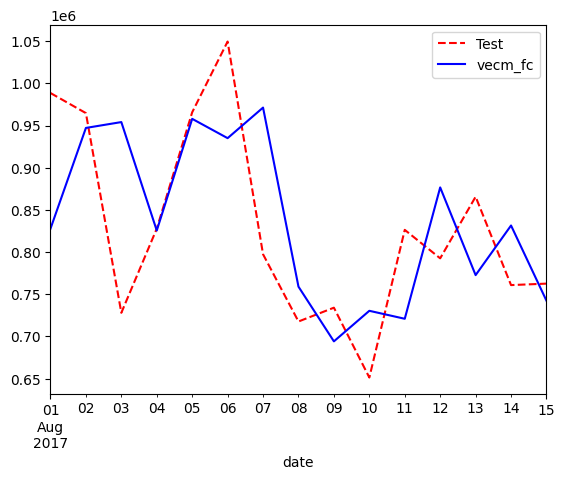

In [99]:
df_vecm_forecast_final['sales'].plot(style = '--', color = 'r', legend = True, label = 'Test')
df_vecm_forecast_final['Predicted Sales'].plot(color = 'b', legend = True, label = 'vecm_fc')

### 4) Conclusion

VECM model performed slightly better than VAR model in predicting Sales, with RMSE of 104042 and MAPE of 10.15%.